In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from collections import defaultdict
import math
import numpy as np
from PIL import Image
import glob
from cvxopt import matrix, solvers
import random
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import time 
import os
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


In [2]:
def gaussian_kernel(x1,x2,gamma =0.001):
    m1 = x1.shape[0]
    m2 = x2.shape[0]
    x1_sq = np.sum(x1**2, axis=1).reshape((m1,1))
    x2_sq = np.sum(x2**2, axis=1).reshape((1,m2))
    k  =np.exp(-gamma * (x1_sq + x2_sq - 2 * (x1 @ x2.T)))
    return k
def calcualte_matrices_gaussian(X,Y,C=1.0):
    t1 = time.time()
    m, n = X.shape
    K = gaussian_kernel(X,X,gamma=0.001)
    P = matrix(np.outer(Y, Y) * K)
    q = matrix(-np.ones(m)) 
    G = matrix(np.vstack((-np.eye(m), np.eye(m))))
    h = matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
    A = matrix(Y, (1, m), 'd')
    b = matrix(0.0)
    
    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h, A, b)  
    alpha = np.ravel(sol['x'])
   

    sv = alpha > 1e-5
    sv_index = np.where(sv)[0]
    print(f"number of support vectors: {len(sv_index)}")
    print(f"percentage of support vectors: {(len(sv_index)/m)*100}%")
    X_sv = X[sv]
    y_sv = Y[sv]
    alpha_sv = alpha[sv]
    t2 = time.time() - t1
    print(f"Time taken to train SVM gaussian using cvxopt: {t2} seconds")
    return X_sv , y_sv ,alpha_sv, alpha 
   


def predict_gaussian(X_sv, y_sv, alpha_sv , X_test ,gamma = 0.001 ,C = 1.0):
    sep_boundary = (alpha_sv > 1e-5) & (alpha_sv < C)
    K_boundary = gaussian_kernel( X_sv[sep_boundary],X_sv , gamma)
    b = y_sv[sep_boundary] - np.sum(alpha_sv * y_sv * K_boundary, axis=1)
    b = np.mean(b)   

    k_test = gaussian_kernel(X_test, X_sv, gamma)
    y_predict = k_test @ (alpha_sv * y_sv) + b 
    return np.sign(y_predict), np.array(y_predict)
       

In [3]:
def get_data(type = "train", labels = ["ship" , "truck"]):
    path = f"data/{type}/{labels[0]}"
    images = [img for img in os.listdir(path) ]
    processed_images = []

    for img in images:
        image = Image.open(os.path.join(path,img)).convert("RGB")
        img_array = np.array(image).reshape(-1)
        processed_images.append(img_array)

    X_ship = np.stack(processed_images)
    Y_ship = np.array([1 for _ in range(X_ship.shape[0])])

    path = f"data/{type}/{labels[1]}"
    images = [img for img in os.listdir(path) ]
    processed_images = []

    for img in images:
        image = Image.open(os.path.join(path,img)).convert("RGB")
        img_array = np.array(image).reshape(-1)
        processed_images.append(img_array)

    X_truck = np.stack(processed_images)
    Y_truck = np.array([-1 for _ in range(X_truck.shape[0])])

    X = np.vstack((X_ship, X_truck))
    X = X/255.0
    Y = np.hstack((Y_ship, Y_truck))

    return X, Y

In [5]:
list_of_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

        


In [6]:

x_store = []
y_store = []

for i in range(len(list_of_labels)):
    label = list_of_labels[i]
    path = f"data/test/{label}"
    images = [img for img in os.listdir(path) ]
    processed_images = []

    for img in images:
        image = Image.open(os.path.join(path,img)).convert("RGB")
        img_array = np.array(image).reshape(-1)
        processed_images.append(img_array)

    X_ship = np.stack(processed_images)
    Y_ship = np.array([i for _ in range(X_ship.shape[0])])
    x_store.append(X_ship)
    y_store.append(Y_ship)

X_test_multi = np.vstack(x_store)/255.0
Y_test_multi = np.hstack(y_store)

In [18]:
print(X_test_multi)

[[0.97647059 0.98431373 0.96470588 ... 0.96470588 0.97254902 0.95294118]
 [0.18823529 0.51372549 0.99215686 ... 0.31372549 0.4745098  0.24705882]
 [0.29803922 0.27058824 0.16078431 ... 0.27843137 0.32941176 0.21176471]
 ...
 [0.83137255 0.86666667 0.99607843 ... 0.19607843 0.2745098  0.40392157]
 [0.53333333 0.53333333 0.53333333 ... 0.54901961 0.52941176 0.64705882]
 [0.96470588 0.98431373 0.99607843 ... 0.83529412 0.82352941 0.75686275]]


In [20]:
t1 = time.time()
clssifier_pair = {}

for i in range(len(list_of_labels)-1):
    for j in range(i+1, len(list_of_labels)):
        label_pair = (list_of_labels[i], list_of_labels[j])

        print(f"Training classifier for labels: {label_pair}")
        X_train, Y_train = get_data("train", labels=list(label_pair))
        
        X_sv, y_sv, alpha_sv, alpha_gaussian = calcualte_matrices_gaussian(X_train, Y_train, C=1.0)
        clssifier_pair[label_pair] = (X_sv, y_sv, alpha_sv)
print(f"Total time taken to train all classifiers: {time.time() - t1} seconds")     
        

Training classifier for labels: ('airplane', 'automobile')
number of support vectors: 1791
percentage of support vectors: 53.71925614877024%
Time taken to train SVM gaussian using cvxopt: 32.555293560028076 seconds
Training classifier for labels: ('airplane', 'bird')
number of support vectors: 1939
percentage of support vectors: 58.15836832633473%
Time taken to train SVM gaussian using cvxopt: 26.32998013496399 seconds
Training classifier for labels: ('airplane', 'cat')
number of support vectors: 1680
percentage of support vectors: 50.38992201559688%
Time taken to train SVM gaussian using cvxopt: 30.821422576904297 seconds
Training classifier for labels: ('airplane', 'deer')
number of support vectors: 1553
percentage of support vectors: 46.58068386322736%
Time taken to train SVM gaussian using cvxopt: 30.29533100128174 seconds
Training classifier for labels: ('airplane', 'dog')
number of support vectors: 1512
percentage of support vectors: 45.350929814037194%
Time taken to train SVM ga

In [21]:
y_predict_pair = {}
for key in clssifier_pair.keys():
    label_pair = key
    X_sv, y_sv, alpha_sv = clssifier_pair[key]
    y_predict_temp,score  = predict_gaussian(X_sv, y_sv, alpha_sv, X_test_multi, gamma=0.001, C=1.0)
    y_predict_pair[label_pair] = (y_predict_temp,score)


In [22]:
print(y_predict_pair[('airplane', 'automobile')])

(array([ 1.,  1., -1., ..., -1., -1., -1.]), array([ 2.02371542,  1.94904685, -0.3802237 , ..., -0.61152597,
       -2.64843087, -0.03629568]))


In [23]:
label_map = {label: idx for idx, label in enumerate(list_of_labels)}
final_prediction = []

for i in range(X_test_multi.shape[0]):
    votes = np.zeros(len(list_of_labels))
    scores = np.zeros(len(list_of_labels))
    for key in y_predict_pair.keys():
        label1, label2 = key
        pred, score = y_predict_pair[key][0][i], y_predict_pair[key][1][i]
        if pred == 1:
            votes[label_map[label1]] += 1
            scores[label_map[label1]] += abs(score)
        else:
            votes[label_map[label2]] += 1
            scores[label_map[label2]] += abs(score)
    tied_labels = np.where(votes == np.max(votes))[0]
    if len(tied_labels) > 1:
        final_label = tied_labels[np.argmax(scores[tied_labels])]
        final_prediction.append(final_label)
    else:            
        final_label = np.argmax(votes)
        final_prediction.append(final_label) 
final_prediction = np.array(final_prediction)
accuracy = accuracy_score(Y_test_multi, final_prediction)
print(f"Final accuracy using One-vs-One SVM with Gaussian kernel: {accuracy*100}%")         
              
        

Final accuracy using One-vs-One SVM with Gaussian kernel: 43.72372372372372%


In [7]:
X_train_multi = []
Y_train_multi = []

for i in range(len(list_of_labels)):
    label = list_of_labels[i]
    path = f"data/train/{label}"
    images = [img for img in os.listdir(path) ]
    processed_images = []

    for img in images:
        image = Image.open(os.path.join(path,img)).convert("RGB")
        img_array = np.array(image).reshape(-1)
        processed_images.append(img_array)

    X_ship = np.stack(processed_images)
    Y_ship = np.array([i for _ in range(X_ship.shape[0])])
    X_train_multi.append(X_ship)
    Y_train_multi.append(Y_ship)

X_train_multi = np.vstack(X_train_multi)/255.0
Y_train_multi = np.hstack(Y_train_multi)

MemoryError: Unable to allocate 391. MiB for an array with shape (16670, 3072) and data type float64

In [25]:
print(X_train_multi.shape)

(16670, 3072)


In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [ ]:
start = time.time()
multi_svm = svm.SVC(kernel='rbf', C=1.0, gamma=0.001 )
multi_svm.fit(X_train_multi, Y_train_multi)
train_time = time.time() - start
print(f"Time taken to train multi-class SVM using sklearn: {train_time} seconds")
y_prediction_sklearn = multi_svm.predict(X_test_multi)
accuracy_sklearn = accuracy_score(Y_test_multi, y_prediction_sklearn)
print(f"Final accuracy using sklearn SVM with Gaussian kernel: {accuracy_sklearn*100}%") 

Time taken to train multi-class SVM using sklearn: 769.7957701683044 seconds
Final accuracy using sklearn SVM with Gaussian kernel: 43.66366366366366%


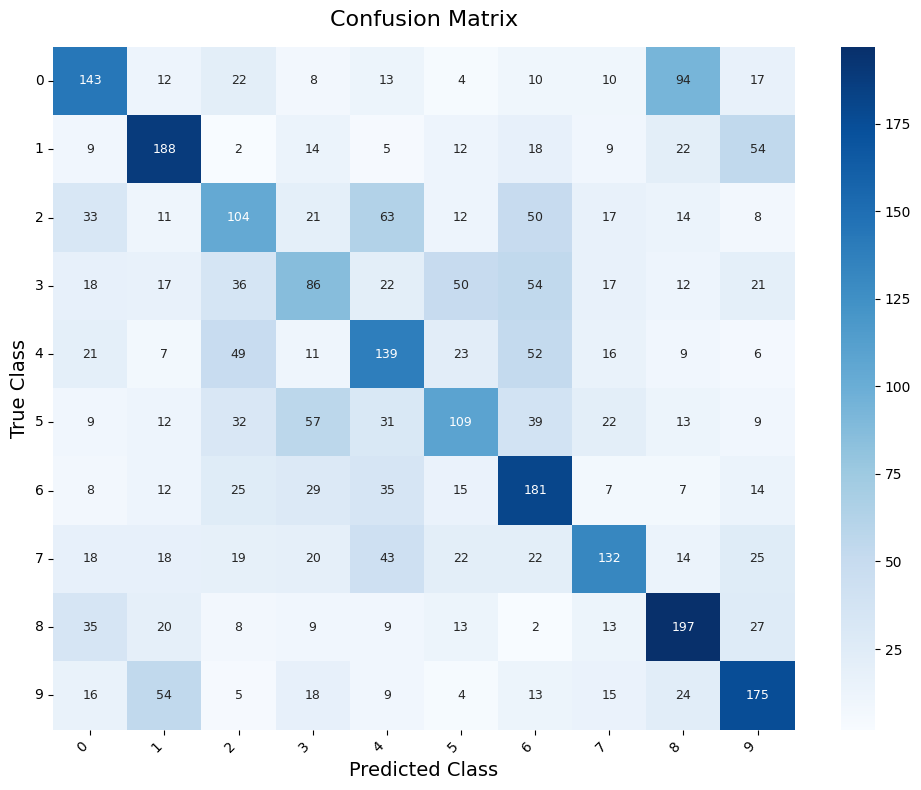

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Compute confusion matrix
cm = confusion_matrix(Y_test_multi,y_prediction_sklearn)
labels = list(range(10))

# Create a bigger, clearer plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True,          # display numbers
    fmt='d',             # integer format
    cmap='Blues',        # color map
    xticklabels=labels, 
    yticklabels=labels,
    cbar=True,
    annot_kws={"size": 9}  # adjust font size for annotations
)

plt.title("Confusion Matrix", fontsize=16, pad=15)
plt.xlabel("Predicted Class", fontsize=14)
plt.ylabel("True Class", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()


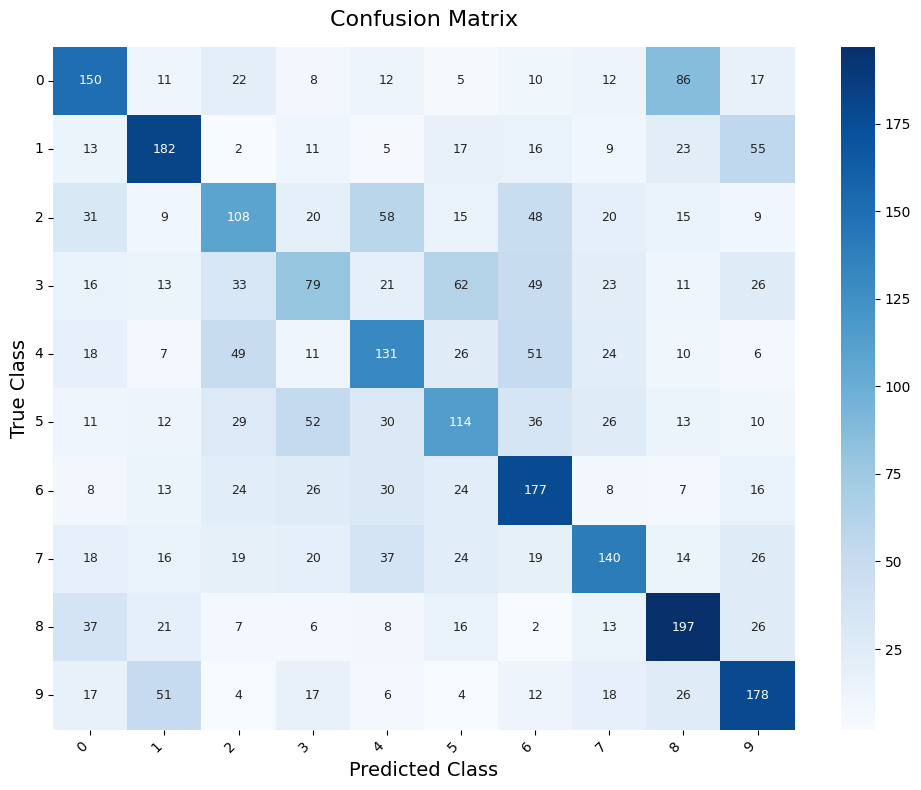

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Compute confusion matrix
cm = confusion_matrix(Y_test_multi,final_prediction)
labels = list(range(10))

# Create a bigger, clearer plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True,          # display numbers
    fmt='d',             # integer format
    cmap='Blues',        # color map
    xticklabels=labels, 
    yticklabels=labels,
    cbar=True,
    annot_kws={"size": 9}  # adjust font size for annotations
)

plt.title("Confusion Matrix", fontsize=16, pad=15)
plt.xlabel("Predicted Class", fontsize=14)
plt.ylabel("True Class", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

In [30]:
wrong_prediction = np.zeros(10)
for i in range(len(Y_test_multi)):
    if Y_test_multi[i] != final_prediction[i]:
        wrong_prediction[Y_test_multi[i]] += 1

max_wrong_predicted_class = list_of_labels[np.argmax(wrong_prediction)]
print(f"Class with maximum wrong predictions for cvxopt: {max_wrong_predicted_class}")

Class with maximum wrong predictions for cvxopt: cat


In [ ]:
wrong_prediction = np.zeros(10)
for i in range(len(Y_test_multi)):
    if Y_test_multi[i] != y_prediction_sklearn[i]:
        wrong_prediction[Y_test_multi[i]] += 1

max_wrong_predicted_class = list_of_labels[np.argmax(wrong_prediction)]
print(f"Class with maximum wrong predictions for sklearn: {max_wrong_predicted_class}")

Class with maximum wrong predictions for sklearn: cat


10 examples of misclassified objets 

10 for cvxopt

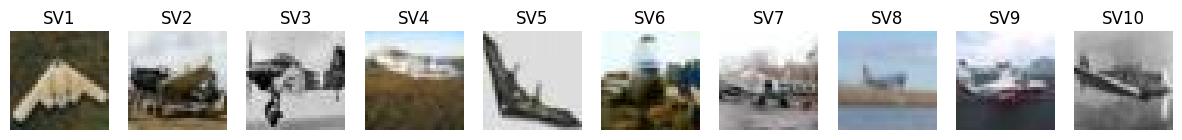

In [ ]:
index = []
for i in range(len(Y_test_multi)):
    if Y_test_multi[i] != final_prediction[i] and Y_test_multi[i]==3:
        index.append(i)
    if len(index) == 10:
        break
X_test_misclassified = X_test_multi[index].reshape(-1,32,32,3)
plt.figure(figsize=(15,3))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X_test_misclassified[i])
    plt.axis('off')
    plt.title(f"SV{i+1}")
plt.show() 
   



10 for slkearn



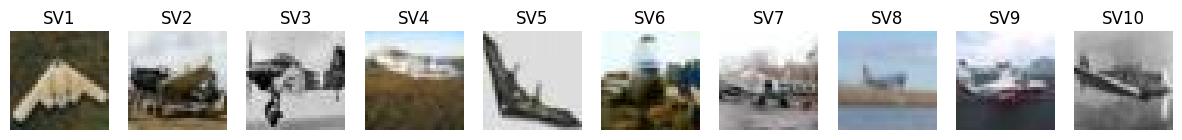

In [33]:
index = []
for i in range(len(Y_test_multi)):
    if Y_test_multi[i] != y_prediction_sklearn[i]:
        index.append(i)
    if len(index) == 10:
        break
X_test_misclassified = X_test_multi[index].reshape(-1,32,32,3)
plt.figure(figsize=(15,3))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X_test_misclassified[i])
    plt.axis('off')
    plt.title(f"SV{i+1}")
plt.show() 

In [ ]:
def f(X_train_multi , Y_train_multi, X_test_multi, Y_test_multi,c):
 
    multi_svm = svm.SVC(kernel='rbf',C=c , gamma=0.001 )
    multi_svm.fit(X_train_multi, Y_train_multi)
    
    y_prediction_sklearn = multi_svm.predict(X_test_multi)
    accuracy_sklearn = accuracy_score(Y_test_multi, y_prediction_sklearn)
    return accuracy_sklearn
   

: 

In [ ]:
idx= np.arange(X_train_multi.shape[0])
np.random.shuffle(idx)
X = X_train_multi[idx]
Y = Y_train_multi[idx]

splits = np.array_split(idx,5)

acc_score = []
test_acc = []

c_values = [10**-5, 10**-3, 1, 5, 10]

for c in c_values:
    acc = []
    for arr in splits:
        X_test , Y_test = X[arr], Y[arr]
        mask = np.ones(len(X), dtype=bool)
        mask[arr] = False
        X_train, Y_train = X[mask], Y[mask]
        acc.append(f(X_train, Y_train, X_test, Y_test,c))

    acc_score.append(np.mean(acc))
    test_acc.append(f(X, Y, X_test_multi, Y_test_multi,c))

print(acc_score)
print(test_acc)




: 

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(c_values, acc_score, '-o', label='CV')
plt.plot(c_values, test_acc, '-o', label='test')
plt.xscale('log',fontsize=12)
plt.xlabel('C values',fontsize = 12)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

: 